In [1]:
import numpy as np
from sklearn import datasets
import matplotlib
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
    #handwritten digits classification using multi-layer perceptron artificial neural network from scratch 

#this notebook will demonstrate how to create an artificial multi-layer perceptron neural network from scratch, making use of 
#only numpy for matrix computations, and train_test_split to split our dataset. We will use the sigmoid function as activation 
#function, our cost function will be an extension of the one used for logistic regression and we will use both batch and 
#stochastic gradient descent as our optimization alogorithms. We will then analyze how well our model generalizes to new data 
#using k-fold cross validation. The steps include:
    #1.) create the network architecture
    #2.) randomly initialize weights based on network architecutre
    #3.) for each training example: feedforward then back propagation to get partial derivatives 
    #4.) update weights using gradient descent (batch/stochastic)
    #5.) repeat steps 3 and 4 for a given number of epochs 
    #6.) use 5-fold cross validation to see how well our results will generalize 

In [3]:
#NOTE: syntax for arrays vs. matrix multiplication
# the * opperand does element-wise multiplication for arrays
# the * opperand does matrix multiplication for matrices 
# the np.dot() command does matrix multiplication for both arrays and matrices 
# the np.multiply() command does element-wise multiplication for both arrays and matrices

In [273]:
#load dataset of handwritten digits from sklearn 
digits = datasets.load_digits()
#num_rows=num training examples 
print digits['data'].shape
#num_cols=num features
print digits['target'].shape
#number of classes = len(digits['target_names])
print digits['target_names']

(1797L, 64L)
(1797L,)
[0 1 2 3 4 5 6 7 8 9]


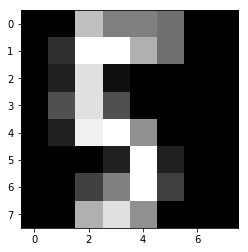

In [274]:
#example of what one of the images from the dataset looks like (8x8 pixels)
plt.gray()
plt.imshow(digits.images[25])
plt.show()

In [275]:
#define sigmoid function. This will be used as the activation function
def sigmoid(z):
    return 1./(1+np.exp(-z))

In [276]:
#define derivative of sigmoid function
def sigmoidGradient(z):
    #check if input is a matrix (need element-wise multiplication)
    if type(z)==np.matrixlib.defmatrix.matrix:
        return np.multiply(z,(1-z))
    else:
        return (z)*(1-z)

In [277]:
#initialize the network architecture. Inputs include:
#       n_inputs = number of inputs in first layer 
#       num_hidden_units = list which contains the number of hidden units in each hidden layer
#       num_hidden_layers = number of hidden layers
#       n_outputs = number of units in the output layer
#this function will return a list which contains each layer of the network as a vector of zeros
def initializeNet(n_inputs,num_hidden_units,num_hidden_layers,n_outputs):
    first_layer = np.zeros((n_inputs,1))
    output_layer = np.zeros((n_outputs,1))
    lis_hidden_layers = []
    lis_hidden_layers.append(first_layer)
    for i in range(num_hidden_layers):
        hidden_layer = np.zeros((num_hidden_units[i],1))
        lis_hidden_layers.append(hidden_layer)
    lis_hidden_layers.append(output_layer)
    return lis_hidden_layers

In [278]:
#this function takes as an input a network which should be the output of the function initializeNet()
#this function randomly initializes the weight matrices used to get from one layer of the network to the next 
#the output will be a list which contains each theta matrix 
def initializeWeights(network):
    num_thetas = len(network)-1
    theta_list = []
    for i in range(num_thetas):
        theta = np.random.randn(len(network[i+1]),len(network[i])+1)
        theta_list.append(theta)
    return theta_list

In [279]:
#this function takes as input:
    #data_labels: the labels for a given dataset
    #num_labels: a list containing each unique label ie. for handwritten digits [0,1,2,3,4,5,6,7,8,9]
#this function will return:
    #y_vector: a matrix with dimensions (num_labels)x(num training examples) where there will be a one indicating that index is 
#the correct label and a zero indicating that index is not the correct label 
def yLabels(data_labels,num_labels):
    y_vector = np.zeros((len(num_labels),data_labels.shape[0]))
    for i in range(data_labels.shape[0]):
        for j in range(len(num_labels)):
            if (data_labels[i]==num_labels[j]):
                y_vector[j,i] = 1
            else:
                y_vector[j,i] = 0
    return y_vector

In [280]:
#this function will update weights, theta by taking a single step of gradient descent 
def gradientDescent(theta,thetGrad,alpha):
    for i in range(len(theta)):
        theta[i]+= -(alpha*thetGrad[i])
    return theta 

In [289]:
#this function takes the training data, randomly initialized weights and the pre-determined architecture for a neural network
#and performs for each training example: feedforward, then backpropagation to get the partial derivatives of the cost function
#with repsect to each weight. The output of this function will be a list of arrays containing partial derivatives. This will 
#be used as the input for gradient descent which is used to update the network weights. 
#this function takes inputs:
        # Xdata- array, train data we are feeding the neural net, 
        # ydata-train data labels 
        # thetas- list, contains randomly initialized weights 
#the output of the function:
        # thetas = list, contains updated matrices of weights after 1 epoch
def propagation(Xdata,ydata,thetas,alpha,lamb):
    #number of examples 
    M = Xdata.shape[0]
    #bias term 
    one = np.array([[1]])
    #create empty matrics that will hold partial derivatives 
    thetasGrad = [np.zeros((thetas[t].shape)) for t in range(len(thetas))]
    
    #loop over each example one at a time, perform feedforward, back propagation, and return matrices of partial derivatives 
    for j in range(Xdata.shape[0]):
        #initialize network archictecutre 
        network = initializeNet(64,[25],1,10)
        #index of the output layer in the network
        output_layer = len(network)-1
        #list that will hold all the deltas from backprop. for each training example 
        delta_list = []
        #set input layer of network (each row of Xdata)
        network[0] = Xdata[[j]].T
        #add bias unit
        network[0] = np.append(one,network[0],axis=0)
        
        #forward propagation
        for i in range(len(thetas)):
            #use theta matrix (weights) to go from one layer to the next
            z = np.dot(thetas[i],network[i])
            #apply activation function
            a = sigmoid(z)
            #fill next layer of network
            network[i+1] = a
            #add bias unit
            if i+1<output_layer:
                network[i+1] = np.append(one,network[i+1],axis=0)
        
        #Backpropagation
        #compute first delta to get error (output-actual) 
        delta = network[output_layer] - ydata[[j]].T
        delta_list.append(delta)
        #this loop will go backwards and compute delta(L-1),delta(L-2),..,delta(2)
        for k in range(len(thetas)-1,0,-1):
            delta = np.dot(thetas[k].T,delta)*sigmoidGradient(network[k])
            delta_list.append(delta)
            
        #remove bias terms after computing deltas (remember output layer doesn't have a bias unit)
        for l in range(1,len(delta_list)):
            temp = delta_list[l]
            delta_list[l] = temp[1:len(temp)]
            
        #compute the gradient of the cost function
        delta_list = list(reversed(delta_list))
        for m in range(len(thetasGrad)):
            thetasGrad[m]+= np.dot(delta_list[m],network[m].T)
            
    #take average over all training examples 
    thetasGrad =  [(1/float(M))*thetasGrad[p] for p in range(len(thetasGrad))]
    
    #add regularization terms to gradients of the cost function
    for n in range(len(thetas)):
        #multiply all columns (except the first)  of the weight matrices by the regularization parameter
        regTemp = [lamb*thetas[n][:,x].reshape(thetas[n].shape[0],1) for x in range(1,thetas[n].shape[1])]
        #combine all regularizaed columns computed above into a single array
        regTempArray = np.concatenate((regTemp),axis=1)
        #append the original first column to the array concatenated above, this is the finished regularized weight matrix
        reg_thetas = np.concatenate((thetas[n][:,0].reshape(thetas[n].shape[0],1),regTempArray),axis=1)
        #add the regularization term to the theta gradient matrix
        thetasGrad[n]+=reg_thetas

    #take a single step of gradient descent (batch gradient descent)        
    update_thetas = gradientDescent(thetas,thetasGrad,alpha)
    
    #return updated weights
    return update_thetas

In [290]:
#this function takes the training data, randomly initialized weights and the pre-determined architecture for a neural network
#and performs for each training example: feedforward, then backpropagation to get the partial derivatives of the cost function
#with repsect to each weight, then updates the weights using stochastic gradient descent. The output of this function is the 
#updated matrices of weights after 1 epoch. 
#STOCHASTIC GRADIENT DESCENT
#this function takes inputs:
        # Xdata- array, train data we are feeding the neural net, 
        # ydata-train data labels 
        # thetas- list, contains randomly initialized weights 
#the output of the function:
        # thetas = list, contains updated matrices of weights after 1 epoch
def stochastic_propagation(Xdata,ydata,thetas,alpha,lamb):
    #number of examples 
    M = Xdata.shape[0]
    #bias term 
    one = np.array([[1]])
    #create empty matrics that will hold partial derivatives 
    thetasGrad = [np.zeros((thetas[t].shape)) for t in range(len(thetas))]
    j=0
    
    while j<M:
        #initialize network archictecutre 
        network = initializeNet(64,[25],1,10)
        #index of the output layer in the network
        output_layer = len(network)-1
        #list that will hold all the deltas from backprop. for each training example 
        delta_list = []
        #set input layer of network (each row of Xdata)
        network[0] = Xdata[[j]].T
        #add bias unit
        network[0] = np.append(one,network[0],axis=0)
        
        #forward propagation
        for i in range(len(thetas)):
            #use theta matrix (weights) to go from one layer to the next
            z = np.dot(thetas[i],network[i])
            #apply activation function
            a = sigmoid(z)
            #fill next layer of network
            network[i+1] = a
            #add bias unit
            if i+1<output_layer:
                network[i+1] = np.append(one,network[i+1],axis=0)
        
        #Backpropagation
        #compute first delta to get error (output-actual) 
        delta = network[output_layer] - ydata[[j]].T
        delta_list.append(delta)
        #this loop will go backwards and compute delta(L-1),delta(L-2),..,delta(2)
        for k in range(len(thetas)-1,0,-1):
            delta = np.dot(thetas[k].T,delta)*sigmoidGradient(network[k])
            delta_list.append(delta)
            
        #remove bias terms after computing deltas (remember output layer doesn't have a bias unit)
        for l in range(1,len(delta_list)):
            temp = delta_list[l]
            delta_list[l] = temp[1:len(temp)]
            
        #compute the gradient of the cost function
        delta_list = list(reversed(delta_list))
        for m in range(len(thetasGrad)):
            thetasGrad[m] = np.dot(delta_list[m],network[m].T)  
        
        #add regularization terms to gradients of the cost function
        for n in range(len(thetas)):
            #multiply all columns (except the first)  of the weight matrices by the regularization parameter (lambda)
            regTemp = [lamb*thetas[n][:,x].reshape(thetas[n].shape[0],1) for x in range(1,thetas[n].shape[1])]
            #combine all regularizaed columns computed above into a single array
            regTempArray = np.concatenate((regTemp),axis=1)
            #append the original first column to the array concatenated above, this is the finished regularized weight matrix
            reg_thetas = np.concatenate((thetas[n][:,0].reshape(thetas[n].shape[0],1),regTempArray),axis=1)
            #add the regularization term to the theta gradient matrix
            thetasGrad[n]+=reg_thetas

        #take a single step of gradient descent for each training example (stochastic gradient desent)
        update_thetas = gradientDescent(thetas,thetasGrad,alpha)
        #update network weights 
        thetas = update_thetas
        #update j to access the next training example
        j+=1
    
    #return updated weights
    return thetas

In [291]:
#once we have found the optimal weights for our neural network this function can be called to make predictions on the train set
#and the test set. The inputs of this function include:
    #Xdata- array, X-matrix data 
    #ydata- array, labels for the X-matrix
    #network- list, in the list are arrays which contain the network architecture 
    #weights- list, in the list is are arrays containing the learned weights for the neural network
#the output of this function is:
    #float(count)./m- float, this is the accuracy of the network (percentage of correct predictions)
def prediction(Xdata,ydata,network,weights):
    #list that will hold output from feedforward
    feedforward_outputs = []
    #bias term 
    one = np.array([[1]])
    #index of the output layer in the network
    output_layer = len(network)-1
    #list that will hold all the predictions 
    predictions = []
    #count of all correct predictions 
    count = 0
    #number of examples 
    m = Xdata.shape[0]
    
    #loop over each example one at a time and perform feedforward 
    for j in range(Xdata.shape[0]):
        #set input layer of network (each row of Xdata)
        network[0] = Xdata[[j]].T
        #add bias unit
        network[0] = np.append(one,network[0],axis=0)
    
        for i in range(len(weights)):
            #use theta matrix (weights) to go from one layer to the next
            z = np.dot(weights[i],network[i])
            #apply activation function
            a = sigmoid(z)
            #fill next layer of network
            network[i+1] = a
            #add bias term for each hidden layer
            if i+1<output_layer:
                network[i+1] = np.append(one,network[i+1],axis=0)
            #store all output-layers in a list     
            else:
                feedforward_outputs.append(network[output_layer])
                
    #loop over all outputs layers and determine the prediciton made by the neural network for each example 
    for k in range(len(feedforward_outputs)):
        #output layer for single example 
        output = feedforward_outputs[k]
        #maximum probability in output layer 
        max_prob = max(output)
        #find index where maximum probability is in output layer 
        pred_d1, pred_d2 = np.where(output == max_prob)
        #this is the correct label for the given example (recall using one-hot encoding each label is a vector)
        label = ydata[k]
        #the index of the correct label for the example 
        ind = np.where(label == 1)
        if ind[0] == pred_d1[0]:
            count+=1
            
    return float(count)/m

In [292]:
#this function will train a neural network and return the optimal weights. As inputs the function will take:
    #X: training data
    #y: labels for training data 
    #weights: randomly initialized weights 
    #epochs: the number of times we will make a full pass through the training data 
    #alpha: step size
    #solver: "stochastic" if we want to use stochastic gradient descent and "full_batch" if we want to use batch gradient descent
#the function will return:
    #weights: the optimal weights found after the given number of epochs
    #weight_history: a list with the updated weights after each epoch 
def trainModel(X,y,weights,epochs,alpha,lamb,solver):
    weight_history = []
    if solver == 'stochastic':
        for i in range(epochs):
            new_weights = stochastic_propagation(X,y,weights,alpha,lamb)
            weight_history.append(new_weights)
            weights = new_weights
        
    elif solver == 'full_batch':
        for j in range(epochs):
            new_weights = propagation(X,y,weights,alpha,lamb)
            weight_history.append(new_weights)
            weights = new_weights
            
    else:
        return 'solver is not recognized: solvers that are supported include, stochastic and full_batch'
            
    return new_weights,weight_history

In [315]:
#this function will perform k-fold cross validation for a given dataset using a nerual network. As inputs the function will 
#take:
    #X - array, Xdata
    #y - array, ydata
    #alpha - float, step-size
    #solver - string, type of optimization algorithm (stochastic or full_batch gradient descent)
    #epochs - int, number of epochs each model will be trained for
    #k - int, number of folds 
#this function will print out the accuracy for each of the k-models that are trained and return the average of those k-accuracies
def kfoldCV(X,y,alpha,lamb,solver,epochs,k):
    #zip together X-data and corresponding labels 
    zipdat = zip(X,y)
    #randomly shuffle data while keeping each example and its labels matched 
    random.shuffle(zipdat)
    #unzip X-data and labels
    X,y = zip(*zipdat)
    #convert X-data and labels from tuples to arrays 
    X = np.asarray(X)
    y = np.asarray(y)
    #convert each label to a vector 
    y = yLabels(y,[0,1,2,3,4,5,6,7,8,9])
    #take transpose of y so each row represents a single example 
    y = y.T
    #set m equal to the number of training examples 
    m = X.shape[0]
    #this will be the size of each partition
    partition = m/k
    
    #create two lists one for the Xfolds and one for the yfolds 
    Xfolds = [X[i*partition:i*partition+partition] for i in range(k)]
    yfolds = [y[i*partition:i*partition+partition] for i in range(k)]
    
    #split dataset into train/test and create a model for each fold and assess each model's accuracy 
    for l in range(k):
        #create two empty lists which will contain the X-data and labels for each of the k-folds
        Xtemp = []
        ytemp = []
        #create an empty list which will hold the k accuracies for each of the k models 
        accuracies = []
        #make the test set one of the k-folds for each model
        Xtest_set = Xfolds[l]
        ytest_set = yfolds[l]
        #loop over all the folds and pull out the ones that are not the test fold for that iteration 
        for m in range(len(Xfolds)):
            if m!=l:
                Xtemp.append(Xfolds[m])
                ytemp.append(yfolds[m])
        #combine so X-data and ydata are arrays 
        Xtemp = np.concatenate((Xtemp),axis=0)
        ytemp = np.concatenate((ytemp),axis=0)
        
        #initialize network and weights for the neural nets. 
        network = initializeNet(64,[25],1,10)
        weights = initializeWeights(network)
        #learn the optimal weights for each of the k models 
        learned_weights = trainModel(Xtemp,ytemp,weights,epochs,alpha,lamb,solver)[0]
        #find the accuracy for each of the k-models and save in list named accuracies 
        accuracies.append(prediction(Xtest_set,ytest_set,network,learned_weights)*100)
        #print the accuracy found for each model
        print accuracies
        
        #return the average of the accuracies found for the k models trained above  
    return np.mean(accuracies)

In [294]:
#this function takes as inputs the hvec, which is a matrix of all the outputs for each example from the feedforward process
#and yvec which represents the labels in vector form where 1=yes, 0=no.. for example for 
#digit recognition, y=3 is [0,0,1,0,0,0,0,0,0,0]
#NOTE: this function does NOT include regularization
def costFunction(hvec,yvec):
    J = 0
    m = hvec.shape[0]
    hvec = np.asarray(hvec)
    yvec = np.asarray(yvec)
    for i in range(0,hvec.shape[0]):
        J = J + (1./m)*(sum((-yvec[:,i].T*np.log(hvec[i,:]))-((1-yvec[:,i].T)*(np.log(1-hvec[i,:])))))
    return J

In [321]:
#load Xdata
Xdata = digits['data']
#load labels
ydata = digits['target']

In [322]:
#one hot encoding for outputs 
ylabels = yLabels(ydata,[0,1,2,3,4,5,6,7,8,9])
#each column corresponds to a single example
y = ylabels.T

In [323]:
#initialize network architecture, 64 features, 1 hidden layer with 25 hidden units, output layer with 10 classes 
network = initializeNet(64,[25],1,10)
#randomly initialize network weights according to the network architecutre
thetas = initializeWeights(network)

In [324]:
#split data set into training set and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, y, test_size=0.33, random_state=42)

In [325]:
#train neural network for 50 epochs using stochastic gradient descent, regularization parameter lambda=0.0001. Print 
#training accuracy for each epoch. 
for i in range(50):
    new = stochastic_propagation(Xtrain,ytrain,thetas,0.010,0.0001)
    print("Train Accuracy: {:.2f}%".format(prediction(Xtrain,ytrain,network,new)*100))
    thetas = new

Train Accuracy: 43.97%
Train Accuracy: 64.84%
Train Accuracy: 75.98%
Train Accuracy: 80.13%
Train Accuracy: 82.96%
Train Accuracy: 83.46%
Train Accuracy: 85.37%
Train Accuracy: 86.37%
Train Accuracy: 87.45%
Train Accuracy: 87.20%
Train Accuracy: 89.36%
Train Accuracy: 89.94%
Train Accuracy: 90.27%
Train Accuracy: 91.69%
Train Accuracy: 92.19%
Train Accuracy: 92.10%
Train Accuracy: 92.19%
Train Accuracy: 93.18%
Train Accuracy: 92.85%
Train Accuracy: 93.43%
Train Accuracy: 94.18%
Train Accuracy: 93.43%
Train Accuracy: 94.18%
Train Accuracy: 94.35%
Train Accuracy: 94.68%
Train Accuracy: 95.01%
Train Accuracy: 94.93%
Train Accuracy: 95.01%
Train Accuracy: 95.76%
Train Accuracy: 95.76%
Train Accuracy: 95.93%
Train Accuracy: 96.18%
Train Accuracy: 95.59%
Train Accuracy: 96.18%
Train Accuracy: 96.26%
Train Accuracy: 96.76%
Train Accuracy: 96.67%
Train Accuracy: 96.59%
Train Accuracy: 96.01%
Train Accuracy: 96.51%
Train Accuracy: 96.34%
Train Accuracy: 96.43%
Train Accuracy: 97.09%
Train Accur

In [326]:
#print test accuracy from optimal weights found above
print("Test Accuracy: {:.2f}%".format(prediction(Xtest,ytest,network,new)*100))

Test Accuracy: 93.94%


In [320]:
#use 5-fold cross validation and take average of the 5 accurcies
kfoldCV(Xdata,ydata,0.01,0.00001,'stochastic',50,5)

[88.3008356545961]
[92.75766016713092]
[94.42896935933148]
[94.70752089136491]
[94.15041782729804]


94.150417827298043